In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import pad_sequences

In [276]:
tf.random.set_seed(42)
np.random.seed(42)

In [277]:
# -------------------------------
# Character-Level Tokenizer and Preprocessing Functions
# -------------------------------
def char_level_tokenizer(texts, num_words=None):
    """
    Create and fit a character-level tokenizer.

    Args:
        texts (list of str): List of texts.
        num_words (int or None): Maximum number of tokens to keep.

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, char_level=True, lower=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

In [278]:
def texts_to_bow(tokenizer, texts):
    """
    Convert texts to a bag-of-characters representation.

    Args:
        tokenizer: A fitted character-level Tokenizer.
        texts (list of str): List of texts.

    Returns:
        Numpy array representing the binary bag-of-characters for each text.
    """
    # texts_to_matrix with mode 'binary' produces a fixed-length binary vector per text.
    matrix = tokenizer.texts_to_matrix(texts, mode='binary')
    return matrix

In [279]:
def one_hot_encode(labels, num_classes=2):
    """
    Convert numeric labels to one-hot encoded vectors.
    """
    return np.eye(num_classes)[labels]

In [280]:
# -------------------------------
# Word-level tokenization
# -------------------------------
def word_level_tokenizer(texts, num_words=None,max_len=None):
    """
    Create and fit a word-level tokenizer.

    Args:
        texts (list of str): List of texts.
        num_words (int or None): Maximum number of tokens to keep.

    Returns:
        tokenizer: A fitted Tokenizer instance.
    """
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, lower=True)
    tokenizer.fit_on_texts(texts)
    return tokenizer

def texts_to_sequence(tokenizer, texts,num_words=None, max_len=None):
    sequences = tokenizer.texts_to_sequences(texts)
    return sequences

In [281]:
# -------------------------------
# Load and Prepare the IMDB Dataset
# -------------------------------
print("Loading IMDB dataset...")
# Load the IMDB reviews dataset with the 'as_supervised' flag so that we get (text, label) pairs.
(ds_train, ds_test), ds_info = tfds.load('imdb_reviews',
                                           split=['train', 'test'],
                                           as_supervised=True,
                                           with_info=True)

Loading IMDB dataset...


In [282]:
# Convert training dataset to lists.
train_texts = []
train_labels = []
for text, label in tfds.as_numpy(ds_train):
    # Decode byte strings to utf-8 strings.
    train_texts.append(text.decode('utf-8'))
    train_labels.append(label)
train_labels = np.array(train_labels)

# Create a validation set from the training data (20% for validation).
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42)

In [283]:
# Convert test dataset to lists.
test_texts = []
test_labels = []
for text, label in tfds.as_numpy(ds_test):
    test_texts.append(text.decode('utf-8'))
    test_labels.append(label)
test_labels = np.array(test_labels)

print(f"Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}, Test samples: {len(test_texts)}")

Train samples: 20000, Validation samples: 5000, Test samples: 25000


In [284]:
# -------------------------------
# Preprocessing: Tokenization and Vectorization
# -------------------------------
tokenizer_char = char_level_tokenizer(train_texts)
tokenizer_word = word_level_tokenizer(train_texts)

# Convert labels to one-hot encoding.
y_train = one_hot_encode(train_labels)
y_val   = one_hot_encode(val_labels)
y_test  = one_hot_encode(test_labels)

In [285]:
#Log the processed data for character-level and word-level tokenization

print(tokenizer_char.word_index)
print(tokenizer_word.word_index)

{' ': 1, 'e': 2, 't': 3, 'a': 4, 'i': 5, 'o': 6, 's': 7, 'n': 8, 'r': 9, 'h': 10, 'l': 11, 'd': 12, 'c': 13, 'm': 14, 'u': 15, 'f': 16, 'g': 17, 'y': 18, 'b': 19, 'w': 20, 'p': 21, '.': 22, 'v': 23, ',': 24, 'k': 25, "'": 26, '/': 27, '>': 28, '<': 29, '-': 30, '"': 31, 'j': 32, 'x': 33, ')': 34, '(': 35, '!': 36, 'z': 37, 'q': 38, '0': 39, '1': 40, '?': 41, ':': 42, '9': 43, '2': 44, '*': 45, ';': 46, '3': 47, '5': 48, '8': 49, '4': 50, '7': 51, '&': 52, '6': 53, 'é': 54, '\x96': 55, '`': 56, '$': 57, '\x85': 58, '=': 59, '_': 60, '%': 61, '+': 62, '\x97': 63, '#': 64, '´': 65, '’': 66, 'è': 67, ']': 68, 'á': 69, '[': 70, '}': 71, '{': 72, '~': 73, '–': 74, '@': 75, '\x91': 76, 'í': 77, 'ô': 78, 'ä': 79, '£': 80, 'ó': 81, 'ü': 82, 'ç': 83, 'à': 84, 'ñ': 85, 'ö': 86, '¨': 87, 'ï': 88, '\t': 89, '^': 90, 'â': 91, '\x84': 92, 'ú': 93, 'å': 94, '»': 95, '½': 96, '\x8e': 97, '\x9e': 98, 'ê': 99, 'ë': 100, '\\': 101, '«': 102, 'ã': 103, '|': 104, '\x95': 105, '·': 106, '“': 107, '”': 108, '

In [286]:
# -------------------------------
# Compare Character-Level Tokenization and Word-Level Tokenization
# -------------------------------

# Vocab size
vocab_char = len(tokenizer_char.word_index) + 1
vocab_word = len(tokenizer_word.word_index) + 1
print("Character-level tokenizer vocabulary size:", vocab_char)
print("Word-level tokenizer vocabulary size:", vocab_word)

Character-level tokenizer vocabulary size: 134
Word-level tokenizer vocabulary size: 80169


In [287]:
#Sequence Comparison
sequence_char_length = [len(i) for i in texts_to_sequence(tokenizer_char,train_texts)]
sequence_word_length = [len(i) for i in texts_to_sequence(tokenizer_word,train_texts)]

min_sequence_char = min(sequence_char_length)
max_sequence_char = max(sequence_char_length)
min_sequence_word = min(sequence_word_length)
max_sequence_word = max(sequence_word_length)

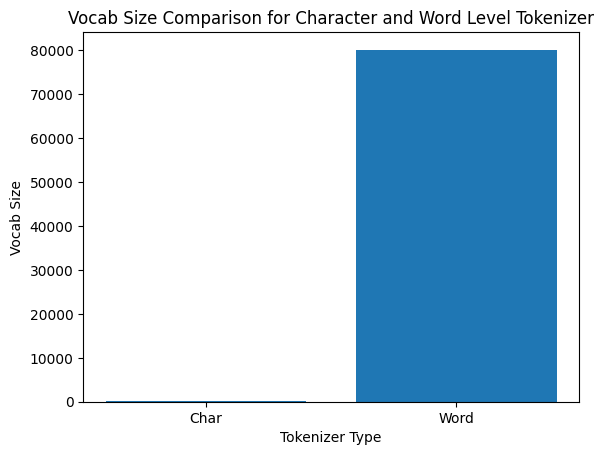

In [288]:
# Compare Character-level tokenizer and Word-level tokenizer vocab size in Column Chart
# Create the column chart
vocab_size = ["Char", "Word"]
values = [vocab_char, vocab_word]
plt.bar(vocab_size, values)

# Add labels and title
plt.xlabel('Tokenizer Type')
plt.ylabel('Vocab Size')
plt.title('Vocab Size Comparison for Character and Word Level Tokenizer')

plt.show()

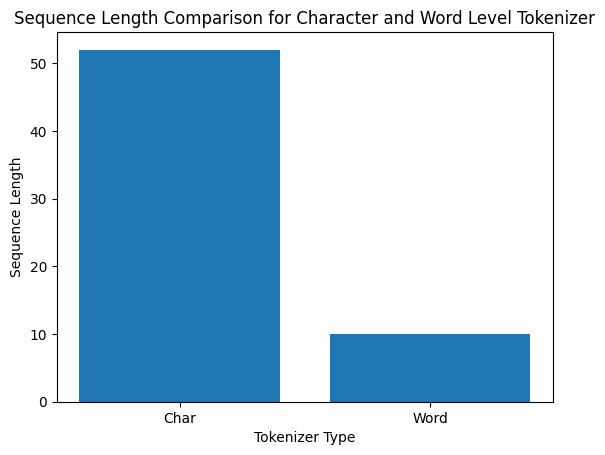

In [289]:
# Compare Character-level tokenizer and Word-level tokenizer in Column Chart
# Create the column chart
sequence_length = ["Char", "Word"]
values = [min_sequence_char, min_sequence_word]
plt.bar(sequence_length, values)

# Add labels and title
plt.xlabel('Tokenizer Type')
plt.ylabel('Sequence Length')
plt.title('Sequence Length Comparison for Character and Word Level Tokenizer')

plt.show()

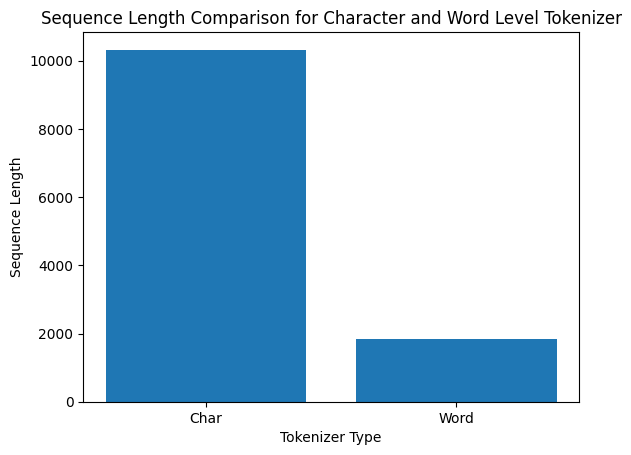

In [290]:
# Compare Character-level tokenizer and Word-level tokenizer in Column Chart
# Create the column chart
sequence_length = ["Char", "Word"]
values = [max_sequence_char, max_sequence_word]
plt.bar(sequence_length, values)

# Add labels and title
plt.xlabel('Tokenizer Type')
plt.ylabel('Sequence Length')
plt.title('Sequence Length Comparison for Character and Word Level Tokenizer')

plt.show()

In [291]:
# Prepare for applying word_level_tokenizer to train, val, and test texts
# Find suitable maxlen
X_sequences = texts_to_sequence(tokenizer_word,train_texts)
max_length = max(len(i) for i in X_sequences) #find max of the sequences
print(max_length)

# Transform train, val, and test texts to sequences
sequence_train = texts_to_sequence(tokenizer_word, train_texts)
sequence_val = texts_to_sequence(tokenizer_word, val_texts)
sequence_test = texts_to_sequence(tokenizer_word, test_texts)

1853


In [292]:
# Declare tokenizer type:
tokenizer = "word"

In [293]:
# -------------------------------
# Pick tokenizer Type
# -------------------------------

if tokenizer == "char":
  # Convert texts to bag-of-characters representation.
  tokenizer = tokenizer_char
  X_train = texts_to_bow(tokenizer_char, train_texts)
  X_val   = texts_to_bow(tokenizer_char, val_texts)
  X_test  = texts_to_bow(tokenizer_char, test_texts)
else:
  tokenizer = tokenizer_word
  X_train = pad_sequences(sequence_train,maxlen=max_length,padding="post")
  X_val   = pad_sequences(sequence_val,maxlen=max_length,padding="post")
  X_test  = pad_sequences(sequence_test,maxlen=max_length,padding="post")

In [294]:
# -------------------------------
# MLP Class Definition that can handle different hidden layers
# -------------------------------
class MLP(object):
    def __init__(self, size_input, size_output, activation, size_hidden1, size_hidden2=None, size_hidden3=None, device=None):
        """
        size_input: int, size of input layer
        size_hidden1: int, size of the 1st hidden layer
        size_hidden2: int, size of the 2nd hidden layer
        size_hidden3: int, size of the 3rd hidden layer (Note: Not used in compute_output in this example)
        size_output: int, size of output layer
        device: str or None, either 'cpu' or 'gpu' or None. If None, the device is decided automatically.
        """
        self.size_input = size_input
        self.size_hidden1 = size_hidden1
        self.size_hidden2 = size_hidden2
        self.size_hidden3 = size_hidden3  # (Currently not used)
        self.size_output = size_output
        self.device = device
        self.activation = activation.lower()

        # -----------------
        # Handle one hidden layer
        # -----------------
        if self.size_hidden2 is None:
          # Initialize weights and biases for first hidden layer
          self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1))
          self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))
          # Initialize weights and biases for output layer
          self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_output], stddev=0.1))
          self.b2 = tf.Variable(tf.zeros([1, self.size_output]))

          self.variables = [self.W1, self.W2, self.b1, self.b2]

        # -----------------
        # Handle two hidden layers
        # -----------------
        elif self.size_hidden2 is not None and self.size_hidden3 is None:
          # Initialize weights and biases for first hidden layer
          self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1))
          self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))

          # Initialize weights and biases for second hidden layer
          self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
          self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

          # Initialize weights and biases for output layer
          self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_output], stddev=0.1))
          self.b3 = tf.Variable(tf.zeros([1, self.size_output]))

          self.variables = [self.W1, self.W2, self.W3, self.b1, self.b2, self.b3]

        # -----------------
        # Handle three hidden layers
        # -----------------
        elif self.size_hidden3 is not None:
          # Initialize weights and biases for first hidden layer
          self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1], stddev=0.1))
          self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1]))

          # Initialize weights and biases for second hidden layer
          self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2], stddev=0.1))
          self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))

          # Initialize weights and biases for third layer
          self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3], stddev=0.1))
          self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))

          # Initialize weights and biases for output layer
          self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output], stddev=0.1))
          self.b4 = tf.Variable(tf.zeros([1, self.size_output]))

          # Define variables to be updated during backpropagation
          self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

    def forward(self, X):
        """
        Forward pass.
        X: Tensor, inputs.
        """
        if self.device is not None:
            with tf.device('gpu:0' if self.device == 'gpu' else 'cpu'):
                self.y = self.compute_output(X)
        else:
            self.y = self.compute_output(X)
        return self.y

    def loss(self, y_pred, y_true):
        """
        Computes the loss between predicted and true outputs.
        y_pred: Tensor of shape (batch_size, size_output)
        y_true: Tensor of shape (batch_size, size_output)
        """
        y_true_tf = tf.cast(y_true, dtype=tf.float32)
        y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
        cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        loss_x = cce(y_true_tf, y_pred_tf)
        return loss_x

    def backward(self, X_train, y_train):
        """
        Backward pass: compute gradients of the loss with respect to the variables.
        """
        with tf.GradientTape() as tape:
            predicted = self.forward(X_train)
            current_loss = self.loss(predicted, y_train)
        grads = tape.gradient(current_loss, self.variables)
        return grads

    def activation_function(self, X):
        """
        Activation function.
        """
        if self.activation == "relu":
            return tf.nn.relu(X)
        elif self.activation == "tanh":
            return tf.nn.tanh(X)
        elif self.activation == "leakyrelu":
            return tf.nn.leaky_relu(X)

    def compute_output(self, X):
        """
        Custom method to obtain output tensor during the forward pass.
        """
        # Cast X to float32
        X_tf = tf.cast(X, dtype=tf.float32)

        # -----------------
        # Handle one hidden layer
        # -----------------
        if self.size_hidden2 is None:
          # First hidden layer
          h1 = tf.matmul(X_tf, self.W1) + self.b1
          z1 = self.activation_function(h1)
          # Output layer (logits)
          output = tf.matmul(z1, self.W2) + self.b2
          return output

        # -----------------
        # Handle two hidden layers
        # -----------------
        elif self.size_hidden2 is not None and self.size_hidden3 is None:
          # First hidden layer
          h1 = tf.matmul(X_tf, self.W1) + self.b1
          z1 = self.activation_function(h1)
          # Second hidden layer
          h2 = tf.matmul(z1, self.W2) + self.b2
          z2 = self.activation_function(h2)
          # Output layer (logits)
          output = tf.matmul(z2, self.W3) + self.b3
          return output

        # -----------------
        # Handle three hidden layers
        # -----------------
        elif self.size_hidden3 is not None:
          # First hidden layer
          h1 = tf.matmul(X_tf, self.W1) + self.b1
          z1 = self.activation_function(h1)
          # Second hidden layer
          h2 = tf.matmul(z1, self.W2) + self.b2
          z2 = self.activation_function(h2)
          # Third hidden layer
          h3 = tf.matmul(z2, self.W3) + self.b3
          z3 = self.activation_function(h3)
          # Output layer (logits)
          output = tf.matmul(z3, self.W4) + self.b4
          return output


In [295]:
# -------------------------------
# Hyperparameter Choices Setup
# -------------------------------
"""
learning_rate = [0.001, 0.0005, 0.0001]
hidden_layers = [1, 2, 3]
hidden_sizes = [128, 256, 512]
batch_sizes = [32, 64, 128]
optimizers = ["Adam", "SGD", "RMSProp"]
activation_functions = ["ReLU", "Tanh", "LeakyReLU"]
"""
hidden_layer = 2
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = None
size_output = 2
activation = "Tanh"
learning_rate = 0.0001
batch_size = 64
optimizer_select = 'adam'

In [296]:
# -------------------------------
# Model Setup
# -------------------------------
# The input size is determined by the dimension of the bag-of-characters vector.
size_input = X_train.shape[1]

# Set up model for different layer size
if hidden_layer == 1:
    model = MLP(size_input, size_output, activation, size_hidden1, device=None)
elif hidden_layer == 2:
    model = MLP(size_input, size_output, activation, size_hidden1, size_hidden2, device=None)
elif hidden_layer == 3:
    model = MLP(size_input, size_output, activation, size_hidden1, size_hidden2, size_hidden3,  device=None)

# Optimizer selection
if optimizer_select == 'adam':
  optimizer = tf.keras.optimizers.Adam(learning_rate)
elif optimizer_select == 'sgd':
  optimizer = tf.keras.optimizers.SGD(learning_rate)
elif optimizer_select == 'rmsprop':
  optimizer = tf.keras.optimizers.RMSprop(learning_rate)

In [297]:
# -------------------------------
# Training Parameters and Loop
# -------------------------------
epochs = 10
num_batches = int(np.ceil(X_train.shape[0] / batch_size))

#Store performance data in lists
train_losses = []
val_losses = []
accuracies = []
precisions = []
recalls = []

print("\nStarting training...\n")
for epoch in range(epochs):
    # Shuffle training data at the start of each epoch.
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]

    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = min((i+1) * batch_size, X_train.shape[0])
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Compute gradients and update weights.
        # with tf.GradientTape() as tape:
        #     predictions = model.forward(X_batch)
        #     loss_value = model.loss(predictions, y_batch)
        # grads = tape.gradient(loss_value, model.variables)
        predictions = model.forward(X_batch)
        loss_value = model.loss(predictions, y_batch)
        grads = model.backward(X_batch, y_batch)
        optimizer.apply_gradients(zip(grads, model.variables))
        epoch_loss += loss_value.numpy() * (end - start)

    epoch_loss /= X_train.shape[0]

    # Evaluate on validation set.
    val_logits = model.forward(X_val)
    val_loss = model.loss(val_logits, y_val).numpy()
    val_preds = np.argmax(val_logits.numpy(), axis=1)
    true_val = np.argmax(y_val, axis=1)
    accuracy = np.mean(val_preds == true_val)
    precision = precision_score(true_val, val_preds)
    recall = recall_score(true_val, val_preds)

    train_losses.append(float(epoch_loss))
    val_losses.append(float(val_loss))
    accuracies.append(float(accuracy))
    precisions.append(float(precision))
    recalls.append(float(recall))

    print(f"Epoch {epoch+1:02d} | Training Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")



Starting training...

Epoch 01 | Training Loss: 0.7422 | Val Loss: 0.7228 | Accuracy: 0.4906 | Precision: 0.4763 | Recall: 0.5103
Epoch 02 | Training Loss: 0.7061 | Val Loss: 0.7102 | Accuracy: 0.5004 | Precision: 0.4859 | Recall: 0.5272
Epoch 03 | Training Loss: 0.6973 | Val Loss: 0.7073 | Accuracy: 0.5034 | Precision: 0.4893 | Recall: 0.5582
Epoch 04 | Training Loss: 0.6944 | Val Loss: 0.7043 | Accuracy: 0.5008 | Precision: 0.4854 | Recall: 0.4934
Epoch 05 | Training Loss: 0.6920 | Val Loss: 0.7037 | Accuracy: 0.5104 | Precision: 0.4955 | Recall: 0.5421
Epoch 06 | Training Loss: 0.6889 | Val Loss: 0.7024 | Accuracy: 0.5064 | Precision: 0.4917 | Recall: 0.5359
Epoch 07 | Training Loss: 0.6871 | Val Loss: 0.7027 | Accuracy: 0.5120 | Precision: 0.4968 | Recall: 0.5165
Epoch 08 | Training Loss: 0.6853 | Val Loss: 0.7022 | Accuracy: 0.5122 | Precision: 0.4971 | Recall: 0.5285
Epoch 09 | Training Loss: 0.6833 | Val Loss: 0.7030 | Accuracy: 0.5144 | Precision: 0.4992 | Recall: 0.5314
Epoch

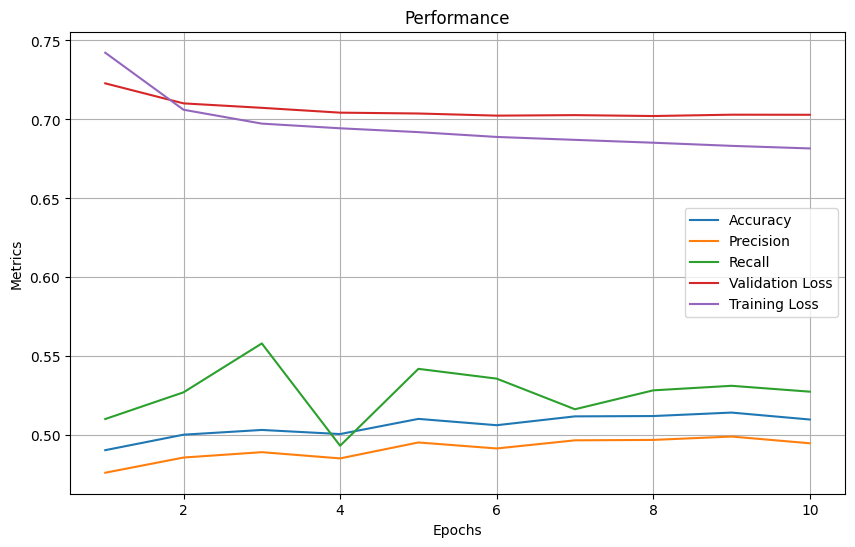

In [298]:

plt.figure(figsize=(10, 6))

# Plot Accuracy, Precision, Recall, and Loss
plt.plot(range(1, epochs+1), accuracies, label="Accuracy")
plt.plot(range(1, epochs+1), precisions, label="Precision")
plt.plot(range(1, epochs+1), recalls, label="Recall")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")


plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Performance")
plt.legend()
plt.grid(True)
plt.show()

In [299]:
#Calculate mean accuracy and standard error
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean accuracy: {mean_accuracy:.4f}")
print(f"Standard error of accuracy: {std_accuracy:.4f}")

Mean accuracy: 0.5061
Standard error of accuracy: 0.0069


In [300]:
# -------------------------------
# Final Evaluation on Test Set
# -------------------------------
print("\nEvaluating on test set...")
test_logits = model.forward(X_test)
test_loss = model.loss(test_logits, y_test).numpy()
test_preds = np.argmax(test_logits.numpy(), axis=1)
true_test = np.argmax(y_test, axis=1)
test_accuracy = np.mean(test_preds == true_test)
test_precision = precision_score(true_test, test_preds)
test_recall = recall_score(true_test, test_preds)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f} | "
      f"Test Precision: {test_precision:.4f} | Test Recall: {test_recall:.4f}")



Evaluating on test set...
Test Loss: 0.7054 | Test Accuracy: 0.5074 | Test Precision: 0.5071 | Test Recall: 0.5330
